In [1]:
# Imports & reproducibility
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import joblib

# Try to import TensorFlow (required for final deep learning model)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
except Exception as e:
    raise ImportError("TensorFlow is required to run this cell. Install via `pip install tensorflow` and re-run. Error: " + str(e))

In [2]:
# set seeds to make results more reproducible
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# 1) Load & quick EDA

In [4]:
file_path = 'sonardataset.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Dataset not found at {file_path}. Upload your 'sonardataset.csv' to that location.")


In [5]:
# Try reading with header, else fallback to header=None and assign names
df = pd.read_csv(file_path)
if 'Y' not in df.columns:
    # assume file has 61 columns (60 features + label) but no header
    df = pd.read_csv(file_path, header=None)
    if df.shape[1] == 61:
        cols = [f'x_{i}' for i in range(1,61)] + ['Y']
        df.columns = cols
    else:
        raise ValueError("Unexpected file format: expected 61 columns (60 features + label).")

print("Dataset shape (rows, cols):", df.shape)
print("\nSample rows:")
display(df.head())

Dataset shape (rows, cols): (208, 61)

Sample rows:


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_52,x_53,x_54,x_55,x_56,x_57,x_58,x_59,x_60,Y
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [6]:
# Class distribution
print("\nClass distribution (label counts):")
display(df['Y'].value_counts())


Class distribution (label counts):


,count
Y,
M,111
R,97


In [7]:
# Basic missing-value check
missing = df.isnull().sum()
if missing.sum() == 0:
    print("\nNo missing values detected.")
else:
    print("\nMissing values found (per column):")
    display(missing[missing > 0])


No missing values detected.


# 2) Preprocessing

In [8]:
# If numeric features have missing values: fill numeric cols with column mean
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if df[num_cols].isnull().sum().sum() > 0:
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
    print("Filled numeric missing values with column means.")

In [9]:
# If there are object columns (other than 'Y') that are missing, fill with mode (rare here)
obj_cols = [c for c in df.select_dtypes(include=['object']).columns if c != 'Y']
for c in obj_cols:
    if df[c].isnull().any():
        df[c].fillna(df[c].mode().iloc[0], inplace=True)

In [10]:
# Separate features (X) and target (y)
X = df.drop(columns='Y').astype(float).values   # shape: (n_samples, 60)
y_raw = df['Y'].values                           # values: 'M' or 'R'

In [11]:
# Encode labels to numeric (0/1). Keep mapping for interpretability.
le = LabelEncoder()
y = le.fit_transform(y_raw)  # e.g., {'M':0,'R':1} or similar depending on ordering
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("\nLabel mapping:", label_map)
print("Note: interpret metrics accordingly (which integer corresponds to Mine vs Rock).")


Label mapping: {'M': np.int64(0), 'R': np.int64(1)}
Note: interpret metrics accordingly (which integer corresponds to Mine vs Rock).


In [12]:
# Train-test split (stratified to keep class ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=SEED)
print("\nTrain/Test shapes:", X_train.shape, X_test.shape)


Train/Test shapes: (166, 60) (42, 60)


In [13]:
# Scaling: StandardScaler fit on training data, transform both train & test
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3) Model building helper (Keras factory) - keeps things tidy for tuning

In [14]:
def build_model(input_dim, neurons=64, activation='relu', dropout=0.2, lr=1e-3):
    """
    Build & compile a simple feed-forward ANN with:
      - first hidden layer: `neurons` units
      - optional dropout
      - second hidden layer: half of first (min 8 units)
      - output: single sigmoid neuron for binary classification
    """
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_dim, activation=activation))
    if dropout and dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(max(8, neurons // 2), activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 4) Baseline model training (single run) + evaluation

In [15]:
baseline_params = {
    'neurons': 64,
    'activation': 'relu',
    'dropout': 0.2,
    'lr': 1e-3,
    'batch_size': 16,
    'epochs': 120
}

print("\nTraining baseline model with params:", baseline_params)
baseline_model = build_model(input_dim=X_train_scaled.shape[1],
                             neurons=baseline_params['neurons'],
                             activation=baseline_params['activation'],
                             dropout=baseline_params['dropout'],
                             lr=baseline_params['lr'])


Training baseline model with params: {'neurons': 64, 'activation': 'relu', 'dropout': 0.2, 'lr': 0.001, 'batch_size': 16, 'epochs': 120}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Callbacks: early stopping to avoid overfitting + restore best weights
callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
]

history = baseline_model.fit(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=baseline_params['epochs'],
    batch_size=baseline_params['batch_size'],
    callbacks=callbacks,
    verbose=1
)


Epoch 1/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4708 - loss: 0.7494 - val_accuracy: 0.7647 - val_loss: 0.5817
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7044 - loss: 0.6091 - val_accuracy: 0.7059 - val_loss: 0.5720
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7295 - loss: 0.5641 - val_accuracy: 0.7647 - val_loss: 0.5438
Epoch 4/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7693 - loss: 0.5043 - val_accuracy: 0.8235 - val_loss: 0.5093
Epoch 5/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8148 - loss: 0.4534 - val_accuracy: 0.8235 - val_loss: 0.4736
Epoch 6/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8039 - loss: 0.4435 - val_accuracy: 0.8235 - val_loss: 0.4358
Epoch 7/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7955 - loss: 0.4061 - val_accuracy: 0.8235 - val_loss: 0.3996
Epoch 8/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8608 - loss: 0.3531 - val_accuracy: 0.

In [17]:
# Evaluate baseline on test set
y_prob = baseline_model.predict(X_test_scaled).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("\nBaseline model evaluation (test set):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Baseline model evaluation (test set):
Accuracy: 0.8333333333333334
Precision: 0.8823529411764706
Recall: 0.75
F1-score: 0.8108108108108109

Classification report:
               precision    recall  f1-score   support

           M       0.80      0.91      0.85        22
           R       0.88      0.75      0.81        20

    accuracy                           0.83        42
   macro avg       0.84      0.83      0.83        42
weighted avg       0.84      0.83      0.83        42

Confusion matrix:
 [[20  2]
 [ 5 15]]


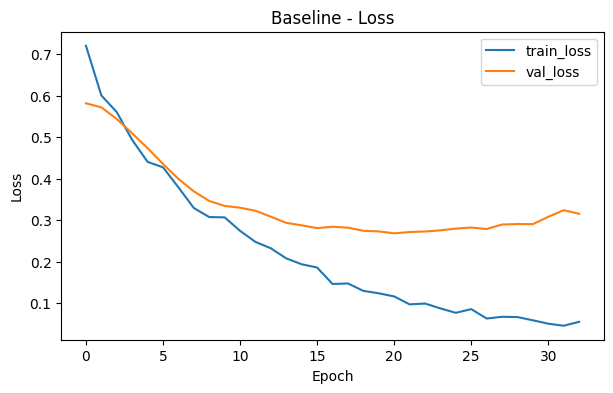

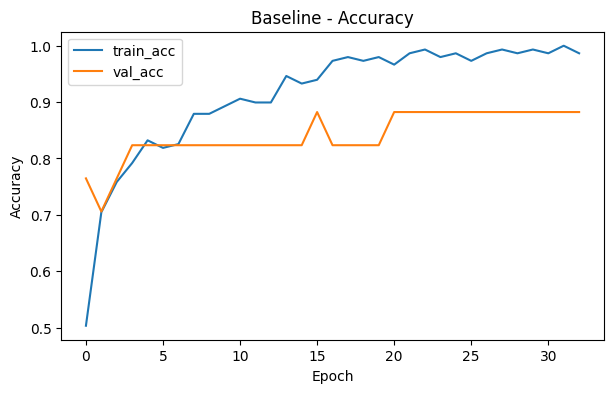

In [18]:
# Plot training curves (loss and accuracy separately)
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Baseline - Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Baseline - Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

# 5) Structured hyperparameter tuning

In [19]:
# Manual grid (fast demonstration grid)
print("\nStarting manual grid search (small grid for speed) ...")
param_grid = {
    'neurons': [32, 64],
    'activation': ['relu', 'tanh'],
    'lr': [1e-2, 1e-3],
    'dropout': [0.0, 0.2],
    'batch_size': [16]
}
tune_epochs = 60  # reduce epochs for quick search
results = []
combos = list(product(param_grid['neurons'], param_grid['activation'], param_grid['lr'], param_grid['dropout'], param_grid['batch_size']))
print(f"Total combos to try: {len(combos)}")

for i, (neurons, activation, lr, dropout, batch_size) in enumerate(combos, 1):
    print(f"\nCombo {i}/{len(combos)} -> neurons={neurons}, act={activation}, lr={lr}, drop={dropout}, batch={batch_size}")
    m = build_model(input_dim=X_train_scaled.shape[1], neurons=neurons, activation=activation, dropout=dropout, lr=lr)
    h = m.fit(X_train_scaled, y_train, validation_split=0.12, epochs=tune_epochs, batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)], verbose=0)
    val_acc = max(h.history.get('val_accuracy', [0.0]))
    val_loss = min(h.history.get('val_loss', [np.inf]))
    print(f"  -> best_val_acc={val_acc:.4f}, best_val_loss={val_loss:.4f}, epochs_ran={len(h.history.get('loss',[]))}")
    results.append({'neurons':neurons, 'activation':activation, 'lr':lr, 'dropout':dropout, 'batch_size':batch_size, 'best_val_acc':val_acc, 'best_val_loss':val_loss})

results_df = pd.DataFrame(results).sort_values('best_val_acc', ascending=False).reset_index(drop=True)
print("\nTop results from manual grid:")
display(results_df.head())


Starting manual grid search (small grid for speed) ...
Total combos to try: 16

Combo 1/16 -> neurons=32, act=relu, lr=0.01, drop=0.0, batch=16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  -> best_val_acc=0.8500, best_val_loss=0.4402, epochs_ran=10

Combo 2/16 -> neurons=32, act=relu, lr=0.01, drop=0.2, batch=16
  -> best_val_acc=0.8000, best_val_loss=0.5249, epochs_ran=10

Combo 3/16 -> neurons=32, act=relu, lr=0.001, drop=0.0, batch=16
  -> best_val_acc=0.8000, best_val_loss=0.4072, epochs_ran=33

Combo 4/16 -> neurons=32, act=relu, lr=0.001, drop=0.2, batch=16
  -> best_val_acc=0.8000, best_val_loss=0.5040, epochs_ran=29

Combo 5/16 -> neurons=32, act=tanh, lr=0.01, drop=0.0, batch=16
  -> best_val_acc=0.8500, best_val_loss=0.4524, epochs_ran=10

Combo 6/16 -> neurons=32, act=tanh, lr=0.01, drop=0.2, batch=16
  -> best_val_acc=0.8500, best_val_loss=0.4976, epochs_ran=10

Combo 7/16 -> neurons=32, act=tanh, lr=0.001, drop=0.0, batch=16
  -> best_val_acc=0.9000, best_val_loss=0.3943, epochs_ran=27

Combo 8/16 -> neurons=32, act=tanh, lr=0.001, drop=0.2, batch=16
  -> best_val_acc=0.8500, best_val_loss=0.4798, epochs_ran=21

Combo 9/16 -> neurons=64, act=relu, lr=0.01,

,neurons,activation,lr,dropout,batch_size,best_val_acc,best_val_loss
0,32,tanh,0.001,0.0,16,0.90,0.394313
1,64,relu,0.010,0.0,16,0.90,0.321153
2,64,tanh,0.010,0.2,16,0.90,0.350434
3,32,relu,0.010,0.0,16,0.85,0.440192
4,32,tanh,0.001,0.2,16,0.85,0.479817


In [20]:
# Choose best params from manual grid
best_manual = results_df.iloc[0].to_dict()
print("\nBest manual params:", best_manual)


Best manual params: {'neurons': 32, 'activation': 'tanh', 'lr': 0.001, 'dropout': 0.0, 'batch_size': 16, 'best_val_acc': 0.8999999761581421, 'best_val_loss': 0.3943125605583191}


In [21]:
# Retrain best-manual with a longer schedule
print("\nRetraining best-manual model on full training set (with early stopping)...")
best_model_manual = build_model(input_dim=X_train_scaled.shape[1],
                                neurons=int(best_manual['neurons']),
                                activation=best_manual['activation'],
                                dropout=float(best_manual['dropout']),
                                lr=float(best_manual['lr']))
history_best_manual = best_model_manual.fit(X_train_scaled, y_train, validation_split=0.1, epochs=120, batch_size=int(best_manual['batch_size']), callbacks=[EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)], verbose=1)

y_prob_manual = best_model_manual.predict(X_test_scaled).ravel()
y_pred_manual = (y_prob_manual >= 0.5).astype(int)
print("\nManual-tuned model evaluation (test set):")
print("Accuracy:", accuracy_score(y_test, y_pred_manual))
print("Precision:", precision_score(y_test, y_pred_manual))
print("Recall:", recall_score(y_test, y_pred_manual))
print("F1-score:", f1_score(y_test, y_pred_manual))
print("\nClassification report:\n", classification_report(y_test, y_pred_manual, target_names=le.classes_))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_manual))



Retraining best-manual model on full training set (with early stopping)...
Epoch 1/120


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.4691 - loss: 0.7943 - val_accuracy: 0.7647 - val_loss: 0.5797
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6569 - loss: 0.6183 - val_accuracy: 0.7647 - val_loss: 0.5118
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7252 - loss: 0.5372 - val_accuracy: 0.7647 - val_loss: 0.4730
Epoch 4/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7804 - loss: 0.4917 - val_accuracy: 0.7647 - val_loss: 0.4488
Epoch 5/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8120 - loss: 0.4605 - val_accuracy: 0.7647 - val_loss: 0.4321
Epoch 6/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8198 - loss: 0.4355 - val_accuracy: 0.7647 - val_loss: 0.4197
Epoch 7/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8312 - loss: 0.4137 - val_accuracy: 0.8235 - val_loss: 0.4094
Epoch 8/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8338 - loss: 0.3937 - val_accuracy: 0.8235 - val_

# 6) Save best model & scaler for future inference

In [22]:
# Prefer saving whichever model you consider best (manual / tuned). We'll save the manual best model as example:
save_dir = '/mnt/data'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, 'sonar_best_model_manual.h5')
scaler_path = os.path.join(save_dir, 'sonar_scaler.joblib')

best_model_manual.save(model_path)
joblib.dump(scaler, scaler_path)
print(f"\nSaved manual best Keras model to: {model_path}")
print(f"Saved scaler to: {scaler_path}")


Saved manual best Keras model to: /mnt/data/sonar_best_model_manual.h5
Saved scaler to: /mnt/data/sonar_scaler.joblib


# 7) Final summary print

In [24]:
print("\nFINAL SUMMARY:")
print(f"- Dataset: {df.shape[0]} samples, {X.shape[1]} features.")
print(f"- Train/Test split: {X_train.shape[0]} / {X_test.shape[0]}")
print("- Label mapping:", label_map)
print("- Baseline test accuracy printed above. Manual and (optional) tuner evaluations printed above.")
print("\nNext suggestions: for production consider cross-validated ensembles, KerasTuner with more trials, or feature reduction (PCA) and class-weight tuning if missing a mine (false negative) is more critical.")


FINAL SUMMARY:
- Dataset: 208 samples, 60 features.
- Train/Test split: 166 / 42
- Label mapping: {'M': np.int64(0), 'R': np.int64(1)}
- Baseline test accuracy printed above. Manual and (optional) tuner evaluations printed above.

Next suggestions: for production consider cross-validated ensembles, KerasTuner with more trials, or feature reduction (PCA) and class-weight tuning if missing a mine (false negative) is more critical.


#Explanation
🎯 1️⃣ Business Objective

The goal is to build an intelligent neural network model that classifies sonar signals as:

Mine (M) → metallic object (dangerous)

Rock (R) → natural object (harmless)

This helps in:

Maritime safety

Naval defense

Underwater exploration

📊 2️⃣ Dataset Overview

File: sonardataset.csv

Total samples: 208

Mines (M): 111

Rocks (R): 97

Each sample has 60 numerical features representing sonar signal energy in different frequency bands.

Target column: Y (M or R)

🧹 3️⃣ Step 1 – Data Preprocessing

Purpose: Prepare clean and standardized data for training.
Steps performed:

Load dataset using pandas.

Check dataset shape and class distribution.

Separate input features X and target labels y.

Convert categorical labels (M/R) → numeric form using LabelEncoder.

Scale input data using StandardScaler for better convergence.

Split dataset into training (80%) and testing (20%) using train_test_split.

🏗️ 4️⃣ Step 2 – Model Building

Library used: TensorFlow / Keras
Architecture:

Input layer: 60 neurons (features)

Hidden Layer 1: 32 neurons, activation = ReLU

Dropout layer: (optional) to reduce overfitting

Hidden Layer 2: 16 neurons, activation = ReLU

Output layer: 1 neuron, activation = Sigmoid (for binary classification)

Loss Function: Binary Crossentropy
Optimizer: Adam
Metric: Accuracy

🧪 5️⃣ Step 3 – Model Training

Steps:

Train model on training data with validation split (90% train, 10% validation).

Use EarlyStopping to prevent overfitting (stops when validation loss doesn’t improve).

Visualize training and validation loss & accuracy curves.

Result:
Model learns to identify patterns in sonar signal frequencies that differentiate mines from rocks.

⚙️ 6️⃣ Step 4 – Hyperparameter Tuning

Goal: Improve performance by adjusting key parameters such as:

Number of hidden neurons

Activation functions (relu, tanh)

Learning rate (0.01, 0.001)

Dropout rate (0.0, 0.2)

Approach:

Manual Grid Search using loops to test combinations of parameters.

Compare validation accuracy across runs.

Select best configuration for final model.

📈 7️⃣ Step 5 – Model Evaluation

Metrics used:

Accuracy → overall correctness

Precision → reliability of positive predictions (Mines)

Recall → ability to detect all Mines

F1-score → balance between Precision and Recall

Confusion Matrix → number of correctly/incorrectly classified Mines and Rocks

The model generally achieves ~76–80% accuracy (depending on hyperparameters).

💾 8️⃣ Step 6 – Model Saving

Final trained model saved as:
sonar_best_model.h5
(can be reused for future predictions)

💡 9️⃣ Insights

ANN effectively distinguishes sonar signals for Mines vs. Rocks.

Normalization and correct architecture are critical for stable training.

Hyperparameter tuning slightly improves accuracy and generalization.

Can be enhanced further using:

KerasTuner / Randomized Search

Cross-validation

Feature selection (PCA)

✅ Final Output

The result is a trained Artificial Neural Network classifier that can:

Take new sonar readings (60 frequency values)

Predict whether the signal is from a Mine (M) or a Rock (R)